# Проект: Статистический анализ данных

**Заголовок:** Анализ данных сервиса аренды самокатов GoFast

**Цель исследования:** Проанализировать данные сервиса аренды самокатов GoFast и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Ход исследования:**
1. Анализ информации о данных: загрузка и изучение общей информации из датасетов
2. Предобработка данных: обработка дубликатов и изменение типов данных
3. Исследовательский анализ данных: описание и визуализация общей информации о пользователях и поездках
4. Объединение данных: формирование датасетов по типу подписки и анализ длительности поездок и расстояний
5. Подсчёт выручки: расчет посячной выручки для каждого пользователя
6. Проверка гипотез: проверка гипотез о "выгодности" пользователей с подпиской для компании
7. Распределения:расчет оптимального количества промокодов и уведомлений

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

In [1]:
#загружаю библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math
from scipy.stats import norm

#### Шаг 1. Загрузка данных

In [2]:
#открываю данные
data_users = pd.read_csv('/datasets/users_go.csv') #информация о пользователях
data_rides = pd.read_csv('/datasets/rides_go.csv') #информация о поездках
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv') #информация о подписках

In [3]:
data_users.info() #изучаю общую информацию о пользователях
print('Количество явных дубликатов в "data_users" = ', data_users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
Количество явных дубликатов в "data_users" =  31


In [4]:
data_rides.info() #изучаю общую информацию о поездках
print('Количество явных дубликатов в "data_rides" = ', data_rides.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
Количество явных дубликатов в "data_rides" =  0


In [5]:
data_subscriptions.info() #изучаю общую информацию о подписках
print('Количество явных дубликатов в "data_subscriptions" = ', data_subscriptions.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
Количество явных дубликатов в "data_subscriptions" =  0


In [6]:
data_users.head() #вывожу первые строки data_users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [7]:
data_rides.head() #вывожу первые строки data_rides

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
data_subscriptions.head() #вывожу первые строки data_subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Выводы:**
    1. В данных users_go.csv 1565 строк. Пропуски отсутствуют, количество явных дубликатов 31.
    2. В данных rides_go.csv 18068 строк. Пропуски отсутствуют, явных дубликатов не обнаружено.
    3. В данных subscriptions_go.csv 2 строки. Пропуски отсутствуют, явных дубликатов нет.

#### Шаг 2. Предобработка данных

**Изменение типов данных**

In [9]:
#привожу столбец date к типу даты datetime64
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')
data_rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [10]:
#проверяю за какой период у нас данные
start_date = data_rides['date'].min()
end_date = data_rides['date'].max()
print(f"Диапазон дат: {start_date.date()} - {end_date.date()}")

Диапазон дат: 2021-01-01 - 2021-12-30


В наших датасетах данные только за 2021 год. Значит при агрегации по месяцам не произойдет ошибки

**Устранение дубликатов**

In [11]:
#устраняю дубликаты в таблице data_users
data_users.drop_duplicates(inplace=True)
data_users.duplicated().sum()

0

**Округление значений**

In [12]:
data_rides['distance'] = data_rides['distance'].round()
data_rides.head()

,user_id,distance,duration,date
0,1,4410.0,25.599769,2021-01-01
1,1,2618.0,15.816871,2021-01-18
2,1,754.0,6.232113,2021-04-20
3,1,2695.0,18.511000,2021-08-11
4,1,4029.0,26.265803,2021-08-28


**Поиск и исправление аномалий**

In [13]:
#поиск аномалий в столбце duration
duration_outliers = data_rides[(data_rides['duration'] < 1) | (data_rides['duration'] > 300)]
if not duration_outliers.empty:
    print("Найдены аномалии в столбце 'duration':")
    print(duration_outliers)
else:
    print("Аномалий в столбце 'duration' не найдено.")

Найдены аномалии в столбце 'duration':
       user_id  distance  duration       date
6531       701    4196.0       0.5 2021-08-31
6570       704    4831.0       0.5 2021-10-14
6680       712    4684.0       0.5 2021-03-04
6695       713    5216.0       0.5 2021-02-25
6768       718    5197.0       0.5 2021-02-11
...        ...       ...       ...        ...
17004     1460    5531.0       0.5 2021-01-19
17242     1477    6725.0       0.5 2021-01-12
17314     1483    4445.0       0.5 2021-03-06
17505     1496    5723.0       0.5 2021-02-14
17909     1524    4104.0       0.5 2021-06-18

[95 rows x 4 columns]


Обнаружено 95 аномально коротких по продолжительности, но не по дистанции поездок. Считаю. что можно заменить для них продолжительность на медианную.

In [14]:
median_duration = data_rides['duration'].median()
data_rides['duration'] = data_rides['duration'].where(
        (data_rides['duration'] >= 1) & (data_rides['duration'] <= 300),
        median_duration
    )
data_rides

,user_id,distance,duration,date
0,1,4410.0,25.599769,2021-01-01
1,1,2618.0,15.816871,2021-01-18
2,1,754.0,6.232113,2021-04-20
3,1,2695.0,18.511000,2021-08-11
4,1,4029.0,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.0,19.822962,2021-11-04
18064,1534,2840.0,21.409799,2021-11-16
18065,1534,3826.0,18.435051,2021-11-18
18066,1534,2902.0,16.674362,2021-11-27


**Добавление столбцов**

In [15]:
#cоздаю новый столбец с номером месяца на основе столбца date
data_rides['month'] = data_rides['date'].dt.month
data_rides.head()

,user_id,distance,duration,date,month
0,1,4410.0,25.599769,2021-01-01,1
1,1,2618.0,15.816871,2021-01-18,1
2,1,754.0,6.232113,2021-04-20,4
3,1,2695.0,18.511000,2021-08-11,8
4,1,4029.0,26.265803,2021-08-28,8


**Заключение**

В ходе предобработки данных:
1. Данные столбца 'date' приведены к типу даты datetime64.
2. Устранены дубликаты в таблице data_users.
3. Расстояния в столбце 'distance' округлены.
4. В столбце 'duration' аномальные значения заменены на медианные.
5. В таблице data_rides создан новый столбец 'month' с номером месяца.

#### Шаг 3. Исследовательский анализ данных

Визуализируем общую информацию о пользователях и поездках:

**Частота встречаемости городов**

In [16]:
data_users['city'].value_counts() #вывожу таблицу пользователей по городам

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

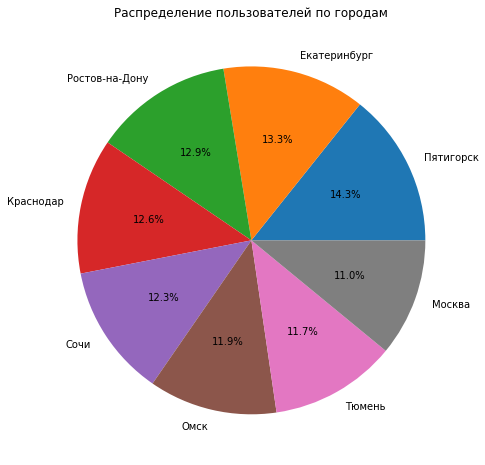

In [17]:
#строю круговую диаграмму
data_users['city'].value_counts().plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%')
plt.title('Распределение пользователей по городам')
plt.ylabel('')
plt.show()

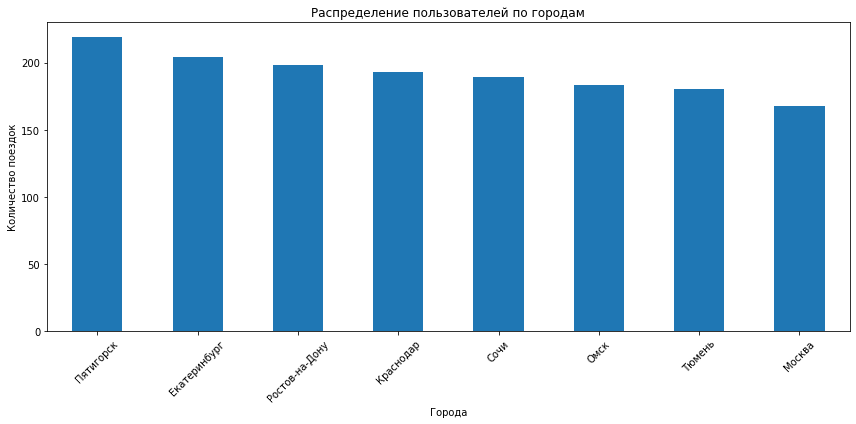

In [18]:
# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
data_users['city'].value_counts().plot(kind='bar')
plt.title('Распределение пользователей по городам')
plt.xlabel('Города')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()  # Уменьшает отступы
plt.show()

Исходя из данных диаграмм количество пользователей распределилось почти равномерно между восьмью городами. Наибольшее количество пользователей в Пятигорске (14,3%), наименьшее в Москве (11%)

**Соотношение пользователей с подпиской и без подписки**

In [19]:
data_users['subscription_type'].value_counts() #вывожу количество пользователей с подписками и без

free     835
ultra    699
Name: subscription_type, dtype: int64

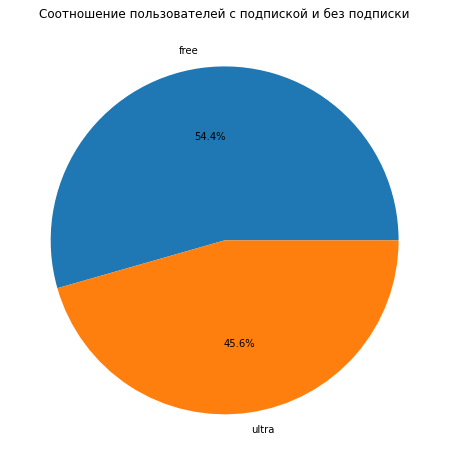

In [20]:
#строю круговую диаграмму
data_users['subscription_type'].value_counts().plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.show()

Согласно диаграмме среди пользователей 54,4% не имеют подписки, а 45,6% оплачивают подписку

**Возраст пользователей**

In [21]:
data_users['age'].describe()#вывожу статистику для столбца age

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

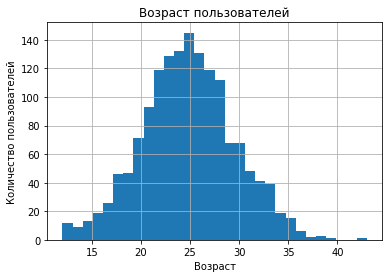

In [22]:
plt.hist(data_users['age'], bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

В основном, сервисом пользуются люди в возрасте от 23 до 28 лет. Больше всего пользователей 25 лет

**Расстояние, которое пользователь преодолел за одну поездку**

In [23]:
data_rides['distance'].describe() #вывожу статистику для столбца distance

count    18068.000000
mean      3070.659010
std       1116.832209
min          1.000000
25%       2543.000000
50%       3134.000000
75%       3776.000000
max       7211.000000
Name: distance, dtype: float64

In [24]:
#создаю функцию для построения гистограммы для расстояния одной поездки
def distance_hist(data, bins):
# построение гистограммы
    plt.hist(data, bins = bins)
    plt.title('Расстояние одной поездки')
    plt.xlabel('Расстояние, м')
    plt.ylabel('Количество поездок')
    plt.grid()
    plt.show()

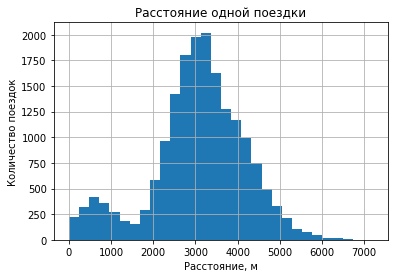

In [25]:
distance_hist(data_rides['distance'], 30)

В основном пользователи проезжают от 2 до 5 км. Медианное значение равно 3 км.

**Продолжительность поездок**

In [26]:
data_rides['duration'].describe() #вывожу статистику для столбца duration

count    18068.000000
mean        17.895334
std          5.959714
min          2.035632
25%         13.697117
50%         17.679120
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [27]:
#создаю функцию для построения гистограммы для продолжительности одной поездки
def duration_hist(data, bins):

    # Построение гистограммы 
    plt.hist(data, bins = bins)
    plt.title('Продолжительность одной поездки')
    plt.xlabel('Время, мин')
    plt.ylabel('Количество поездок')
    plt.grid()
    plt.show()

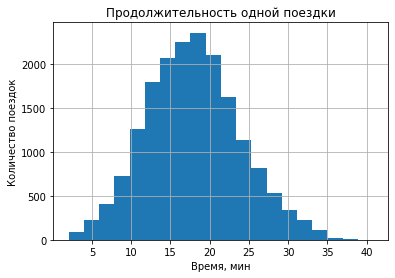

In [28]:
duration_hist(data_rides['duration'], 20)

Все поездки длятся не больше 40 мин. Половина всех поездок занимает от 13 до 21 минуты

**Выводы:**
1. Количество пользователей распределилось почти равномерно между восьмью городами. Наибольшее количество пользователей в Пятигорске (14,3%), наименьшее в Москве (11%)
2.54,4% пользователей не имеют подписки, а 45,6% оплачивают подписку
3. В основном, сервисом пользуются люди в возрасте от 23 до 28 лет. Больше всего пользователей 25 лет
4. В основном пользователи проезжают от 2 до 5 км. Медианное значение равно 3 км.
5.Длительность поездки состовляет 13 - 22 минут

#### Шаг 4. Объединение данных

In [29]:
#смотрю размерность таблиц
print("Размерность data_users:", data_users.shape)
print("Размерность data_subscriptions:", data_subscriptions.shape)
print("Размерность data_rides:", data_rides.shape)

Размерность data_users: (1534, 5)
Размерность data_subscriptions: (2, 4)
Размерность data_rides: (18068, 5)


In [30]:
# Объединеняю данные пользователей и подписок
merged_users_subscriptions = data_users.merge(data_subscriptions, on='subscription_type', how='left')

# Объединяю с данными о поездках
full_data = merged_users_subscriptions.merge(data_rides, on='user_id', how='left')

display(full_data.head())

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4410.0,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2618.0,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.0,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2695.0,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4029.0,26.265803,2021-08-28,8


In [31]:
print("Размерность объединенной таблицы:", full_data.shape)

Размерность объединенной таблицы: (18068, 12)


Размерность объединенной таблицы совпадает с размерностью data_rides

In [32]:
print("Количество пропусков в объединенном датасете:\n", full_data.isnull().sum())

Количество пропусков в объединенном датасете:
 user_id              0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
distance             0
duration             0
date                 0
month                0
dtype: int64


Пропусков в новой таблице нет

In [33]:
# создаю датафрейм с пользователями с подпиской "free"
users_free_subscription = full_data[full_data['subscription_type'] == 'free']
users_free_subscription.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2516.0,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,847.0,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.0,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1206.0,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.0,17.427673,2021-02-14,2


In [34]:
# создаю датафрейм с пользователями с подпиской "ultra"
users_ultra_subscription = full_data[full_data['subscription_type'] == 'ultra']
users_ultra_subscription.head()

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4410.0,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2618.0,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.0,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2695.0,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4029.0,26.265803,2021-08-28,8


**Расстояние и время одной поездки в зависимости от типа подписки**

Без подписки:

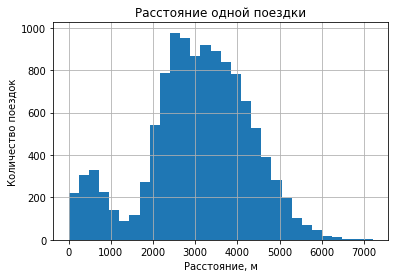

In [35]:
distance_hist(users_free_subscription['distance'], 30) 

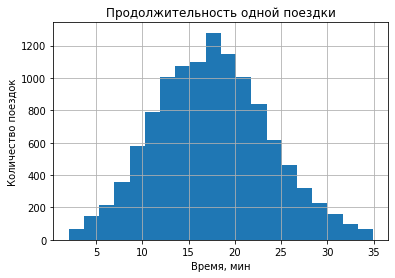

In [36]:
duration_hist(users_free_subscription['duration'], 20)

С подпиской:

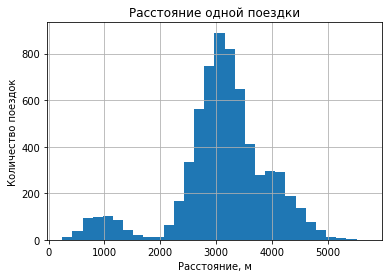

In [37]:
distance_hist(users_ultra_subscription['distance'], 30)

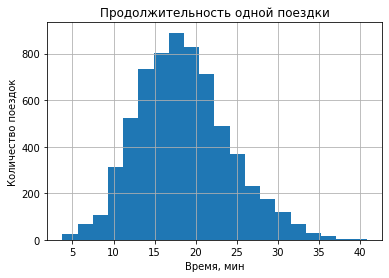

In [38]:
duration_hist(users_ultra_subscription['duration'], 20)

**Выводы:**

Объединили данные о пользователях, поездках и тарифах в один датафрейм, который назвали full_data.

Из полученного датафрейма мы выделили две группы:

users_free_subscription — информация о пользователях, у которых активирован бесплатный тариф.
users_ultra_subscription — информация о пользователях, пользующихся платным тарифом.
Визуализировали данные о расстоянии и времени поездок для каждой из тарифных категорий.

По данным бесплатного тарифа, время поездки варьируется от 10 до 30 минут, а расстояние составляет от 2 до 5 км. Кроме того, некоторые пользователи преодолевают расстояния до 6 и 6,5 км.

Что касается платного тарифа, то среднее время поездки в основном находится в диапазоне от 15 до 25 минут, а максимальные расстояния фиксируются примерно на уровне 3 км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в общем совершают более длительные поездки и проезжают большее расстояние по сравнению с пользователями платного тарифа.

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках для каждого пользователя за каждый месяц.

In [39]:
aggregated_data = full_data.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_distance=('distance', 'sum'),           # суммарное расстояние
    total_trips=('distance', 'count'),            # количество поездок
    total_time=('duration', 'sum')                    # суммарное время
).reset_index()

# вывожу агрегированный датафрейм
print("Агрегированные данные о поездках:")
aggregated_data.head()

Агрегированные данные о поездках:


,user_id,month,subscription_type,total_distance,total_trips,total_time
0,1,1,ultra,7028.0,2,41.416640
1,1,4,ultra,754.0,1,6.232113
2,1,8,ultra,6724.0,2,44.776802
3,1,10,ultra,5810.0,2,31.578017
4,1,11,ultra,7004.0,3,53.397424


Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [40]:
# функция для расчета выручки
def calculate_revenue(row):
    if row['subscription_type'] == 'free':
        start_cost = 50
        minute_cost = 8
        subscription_cost = 0
    elif row['subscription_type'] == 'ultra':
        start_cost = 0
        minute_cost = 6
        subscription_cost = 199
    
    revenue = (start_cost * row['total_trips']) + (minute_cost * row['total_time']) + subscription_cost
    return revenue

# применяю функцию к каждой строке
aggregated_data['revenue'] = aggregated_data.apply(calculate_revenue, axis=1)

# вывожу датафрейм
display(aggregated_data)

,user_id,month,subscription_type,total_distance,total_trips,total_time,revenue
0,1,1,ultra,7028.0,2,41.416640,447.499843
1,1,4,ultra,754.0,1,6.232113,236.392681
2,1,8,ultra,6724.0,2,44.776802,467.660815
3,1,10,ultra,5810.0,2,31.578017,388.468102
4,1,11,ultra,7004.0,3,53.397424,519.384541
...,...,...,...,...,...,...,...
11326,1534,6,free,3409.0,2,24.812678,298.501421
11327,1534,8,free,7623.0,2,47.205960,477.647678
11328,1534,9,free,4928.0,1,22.560373,230.482980
11329,1534,11,free,13349.0,4,76.342174,810.737395


**Заключение:**
Создан новый датафрейм с агрегированными данными (aggregated_data) на основе датафрейма с объединенными данными (full_data).

Найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавили столбец с помесячной выручкой, которую принес каждый пользователь.

#### Шаг 6. Проверка гипотез

**Тратят ли пользователи с подпиской больше времени на поездки?**

Проверим гипотезу: пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.

H0: Время (duration) пользователей на подписке ultra = время (duration) пользователей без подписки free

H1: Время (duration) пользователей на подписке ultra > время (duration) пользователей без подписки free

alpha = 0.05

In [41]:
results = st.ttest_ind(users_ultra_subscription['duration'], 
                       users_free_subscription['duration'],
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

3.3080597507158844e-28
Отвергаем нулевую гипотезу


Пользователи с подпиской «выгоднее» для компании, они тратят больше времени на поездки

**Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Проверим гипотезу: реднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

H0: Расстояние одной поездки (distance) пользователей на подписке ultra <= 3130 м

H1: Расстояние одной поездки (distance) пользователей на подписке ultra > 3130 м

alpha = 0.05

In [42]:
results = st.ttest_1samp(users_ultra_subscription['distance'], 
                       3130,
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195649894697724
Не удалось отвергнуть нулевую гипотезу


Cреднее расстояние поездки, пользователей с подпиской, не превышает оптимальное расстоянием в 3130 м

**Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**

Проверим гипотезу: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

H0: Помесячная выручка (revenue) пользователей на подписке ultra <= помесячной выручка (revenue) пользователей без подписки free

H1: Помесячная выручка (revenue) пользователей на подписке ultra > помесячной выручка (revenue) пользователей без подписки free

alpha = 0.05

In [43]:
results = st.ttest_ind(aggregated_data.loc[aggregated_data['subscription_type'] == 'ultra', 'revenue'], 
                       aggregated_data.loc[aggregated_data['subscription_type'] == 'free', 'revenue'],
                       alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2806697348843778e-33
Отвергаем нулевую гипотезу


Есть основания утверждать, что средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки, при установленном уровне значимости в 5 %

**Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Поскольку две выбоки до и после, можно применить scipy.stats.ttest_rel(), и альтернативная гипотеза будет односторонняя alternative='less'

**Вывод:**

Пользователи с подпиской «выгоднее» для компании, они тратят больше времени на поездки и средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки. При этом среднее расстояние поездки, пользователей с подпиской, не превышает оптимальное расстоянием в 3130 м, а значит поездки пользователей с подпиской не приводят к существенному износу самокатов

#### Шаг 7. Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [44]:
p = 0.1  # вероятность успеха (продление подписки)
k = 100  # минимальное количество клиентов, продливших подписку
confidence_level = 0.95  # уровень доверия

# нахожу Z-критерий для заданного уровня доверия
z = st.norm.ppf((1 + confidence_level) / 2)

def minimum_n(p, k, z):    
    N = k # начальная оценка N
    while True:
        # вычисляю стандартное отклонение
        stddev = np.sqrt(N * p * (1 - p))
        # использую нормальное приближение к биномиальному распределению
        # вычисляю вероятность P(X >= k)
        mean = N * p
        prob = 1 - st.norm.cdf(k - 0.5, loc=mean, scale=stddev)
        
        if prob >= confidence_level:  
            break
        
        N += 1  

    return N

required_n = minimum_n(p, k, z)
print(f"Необходимое количество промокодов: {required_n}")

Необходимое количество промокодов: 1164


**Вывод:**

Для того чтобы как минимум 100 существующих клиентов продлили подписку, необходимо разослать не менее 1164 промокода. При этом вероятность того, что план не будет выполнен, составляет 5%, учитывая, что 10% получивших промокоды продлевают свою подписку.

In [45]:
N = 1000000  # общее количество уведомлений
p = 0.4      # вероятность, что пользователь открывает уведомление

mu = N * p
sigma = np.sqrt(N * p * (1 - p))
x = 399500

z = (x - mu) / sigma

probability = norm.cdf(z)

print(f"Вероятность того, что уведомление откроют не более 399,500 пользователей: {probability:.4f}")

Вероятность того, что уведомление откроют не более 399,500 пользователей: 0.1537


**Вывод:**

Если отправить 1 миллион уведомлений, из которых лишь 40 % клиентов откроют их, вероятность того, что количество открытых уведомлений не превысит 399,5 тысяч пользователей, составит 0,1537 или 15,37 %.

**Общий вывод:**

В ходе исследования данных сервиса аренды самокатов GoFast были выполнены следующие этапы, а также сделаны соответствующие выводы:

**1. Анализ информации о данных**

В данных users_go.csv 1565 строк. Пропуски отсутствуют, количество явных дубликатов 31. В данных rides_go.csv 18068 строк. Пропуски отсутствуют, явных дубликатов не обнаружено. В данных subscriptions_go.csv 2 строки. Пропуски отсутствуют, явных дубликатов нет.

**2. Предобработка данных**

В процессе предобработки данных были внесены следующие изменения:
1. Данные столбца 'date' приведены к типу даты datetime64.
2. Устранены дубликаты в таблице data_users.
3. Расстояния в столбце 'distance' округлены.
4. В столбце 'duration' аномальные значения заменены на медианные.
5. В таблице data_rides создан новый столбец 'month' с номером месяца.

**3. Исследовательский анализ данных**

1. Количество пользователей распределилось почти равномерно между восьмью городами. Наибольшее количество пользователей в Пятигорске (14,3%), наименьшее в Москве (11%)
2.54,4% пользователей не имеют подписки, а 45,6% оплачивают подписку
3. В основном, сервисом пользуются люди в возрасте от 23 до 28 лет. Больше всего пользователей 25 лет
4. В основном пользователи проезжают от 2 до 5 км. Медианное значение равно 3 км.
5.Длительность поездки состовляет 13 - 22 минут

**4. Объединение данных**

Объединили данные о пользователях, поездках и тарифах в один датафрейм, который назвали full_data.

Из полученного датафрейма мы выделили две группы:

users_free_subscription — информация о пользователях, у которых активирован бесплатный тариф. users_ultra_subscription — информация о пользователях, пользующихся платным тарифом. Визуализировали данные о расстоянии и времени поездок для каждой из тарифных категорий.

По данным бесплатного тарифа, время поездки варьируется от 10 до 30 минут, а расстояние составляет от 2 до 5 км. Кроме того, некоторые пользователи преодолевают расстояния до 6 и 6,5 км.

Что касается платного тарифа, то среднее время поездки в основном находится в диапазоне от 15 до 25 минут, а максимальные расстояния фиксируются примерно на уровне 3 км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в общем совершают более длительные поездки и проезжают большее расстояние по сравнению с пользователями платного тарифа.

**5. Подсчёт выручки**

Создан новый датафрейм с агрегированными данными (aggregated_data) на основе датафрейма с объединенными данными (full_data).

Найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавили столбец с помесячной выручкой, которую принес каждый пользователь.

**6. Проверка гипотез**

Гипотеза о том, что пользователи с подпиской «выгоднее» для компании, они тратят больше времени на поездки, оказалась верна
Гипотеза о том, что среднее расстояние поездки, пользователей с подпиской, не превышает оптимальное расстоянием в 3130 м
Гипотеза о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки оказалась верна.

Таким образом, пользователи с подпиской «выгоднее» для компании, они тратят больше времени на поездки и средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки. При этом среднее расстояние поездки, пользователей с подпиской, не превышает оптимальное расстоянием в 3130 м, а значит поездки пользователей с подпиской не приводят к существенному износу самокатов.

**7. Распределения**

1. Для того чтобы как минимум 100 существующих клиентов продлили подписку, необходимо разослать не менее 1164 промокода. При этом вероятность того, что план не будет выполнен, составляет 5%, учитывая, что 10% получивших промокоды продлевают свою подписку.

2. Если отправить 1 миллион уведомлений, из которых лишь 40 % клиентов откроют их, вероятность того, что количество открытых уведомлений не превысит 399,5 тысяч пользователей, составит 0,1537 или 15,37 %.

**Заключение**

Пользователи с подпиской предоставляют сервису аренды самокатов большую выгоду, поэтому руководству компании следует предпринять шаги для увеличения числа клиентов, оформляющих подписку